In [1]:
import jax
import jax.numpy as jnp

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from cartm.model import ContextTopicModel
from cartm.prepocessing import DatasetPreprocessor
from cartm.metrics import TopicVarianceMetric
from cartm.regularization import (
    Regularization,
    DecorrelationRegularization,
)

In [2]:
sns.set_theme()

This example notebook shows how to use predefined regularizations and write your own custom regularizations.

It is recommended to read `metrics.ipynb` notebook first.

In [3]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
print(f'Total number of documents in corpus: {len(data)}')
print(f'Total number of words in corpus: {sum([len(doc.split(' ')) for doc in data])}')

Total number of documents in corpus: 18846
Total number of words in corpus: 5937230


In [4]:
preprocessor = DatasetPreprocessor()
tokenized_data, document_bounds = preprocessor.fit_transform(data)
print(f'Total number of document boundaries in preprocessed corpus: {len(document_bounds)}')
print(f'Total number of tokenized words in preprocessed corpus: {len(tokenized_data)}')

Total number of document boundaries in preprocessed corpus: 18847
Total number of tokenized words in preprocessed corpus: 3535392


## Basic usage of predefined regularizations

### Creating new regularization

Each regularization represents a subclass of an abstract `Regularization` class. To define a new regularization and use it in your model, you can create an instance of the regularization you need and pass it to constructor of the model. Alternatively, you can use `add_regularization` method of `ContextTopicModel` class to add a new regularization after the creation of the model. To remove a regularization from the model, use `remove_regularization` method.

In [5]:
decorrelator = DecorrelationRegularization(tau=0.3)

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
    regularizers=[decorrelator],
)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=1,
    seed=42,
)

Iteration [1/5], phi update diff norm: 0.1357
Iteration [2/5], phi update diff norm: 0.0177
Iteration [3/5], phi update diff norm: 0.0221
Iteration [4/5], phi update diff norm: 0.0360
Iteration [5/5], phi update diff norm: 0.0545


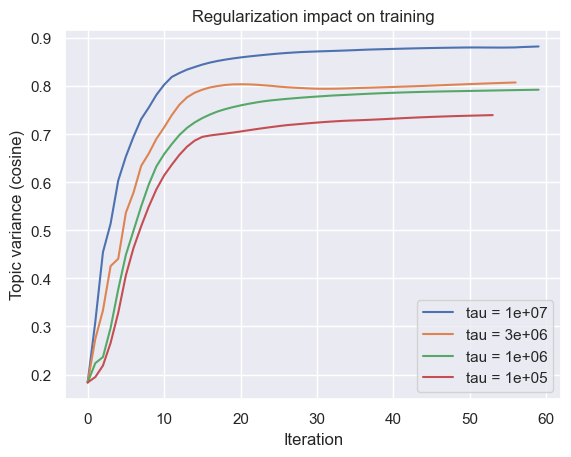

In [6]:
for tau in [1e7, 3e6, 1e6, 1e5]:
    decorrelator = DecorrelationRegularization(tau=tau)
    topic_variance_mtc = TopicVarianceMetric(distance_metric='cosine')

    model = ContextTopicModel(
        vocab_size=len(preprocessor.vocabulary),
        ctx_len=10,
        metrics=[topic_variance_mtc],
    )
    model.add_regularization(decorrelator)

    model.fit(
        data=tokenized_data,
        ctx_bounds=document_bounds,
        max_iter=60,
        verbose=0,
        seed=42,
    )

    plt.plot(topic_variance_mtc.history, label=f'tau = {tau:.1g}')

plt.title('Regularization impact on training')
plt.xlabel('Iteration')
plt.ylabel('Topic variance (cosine)')
plt.legend()
plt.show()

## Tagging regularizations

Regularizations support tags (labels) for custom naming. Thus, you can use one regularization with different parameters in one model. 

Pay attention that, due to differentiation rules, using multiple instances of one regularization with different regularization coefficients (tau) is equivalent to using only one regularization with tau equal to the sum of regularization coefficients.

In [7]:
decorrelator = DecorrelationRegularization(
    tau=0.3, tag='decorrelation'
)

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
    regularizers=[decorrelator],
)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=1,
    seed=42,
)
model.remove_regularization(tag='decorrelation')

Iteration [1/5], phi update diff norm: 0.1357
Iteration [2/5], phi update diff norm: 0.0177
Iteration [3/5], phi update diff norm: 0.0221
Iteration [4/5], phi update diff norm: 0.0360
Iteration [5/5], phi update diff norm: 0.0545


## Advanced usage of regularizations

### Creating a custom regularization

Creating a new regularization requires creating a subclass of `Regularization` base class and implementing `__init__` and `_call_impl` methods. It is necessary to implement regularizations to be compatible with `jax.grad`.

In [8]:
class PhiNormRegularization(Regularization):
    def __init__(self, tau: float, tag: str = None):
        if tag is None:
            tag = self.__class__.__name__
        super().__init__(tag=tag, tau=tau)  # tau is applied in base class wrapper

    def _call_impl(self, phi_wt: jax.Array) -> float:
        norm = jnp.sum(phi_wt)
        return norm  # do not apply tau coefficient here!

In [9]:
custom_reg = PhiNormRegularization(tau=0.3)
reg_grad = jax.grad(custom_reg)

# if this line works correctly, everything is likely
# to be ok with your regularization
reg_grad(jnp.zeros((5, 5)))

Array([[0.3, 0.3, 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3],
       [0.3, 0.3, 0.3, 0.3, 0.3]], dtype=float32)

In [10]:
norm_regularization = PhiNormRegularization(tau=0.3)

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)
model.add_regularization(norm_regularization)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=2,
    seed=42,
)

Iteration [1/5], phi update diff norm: 0.1357
Iteration [2/5], phi update diff norm: 0.0177
Iteration [3/5], phi update diff norm: 0.0221
Iteration [4/5], phi update diff norm: 0.0360
Iteration [5/5], phi update diff norm: 0.0545
